# 주가예측 모델
## 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

rcParams['figure.figsize'] = 13, 6

## 데이터 로드&전처리(삼성전자, NAVER, 우리금융그룹)

Samsung Electronics ----------------
Date
2021-02-15    11.340950
2021-02-16    11.349229
2021-02-17    11.329003
2021-02-18    11.315693
2021-02-19    11.321765
Name: Close, dtype: float64

NAVER ----------------
Date
2021-02-15    12.862296
2021-02-16    12.884106
2021-02-17    12.879017
2021-02-18    12.868761
2021-02-19    12.894207
Name: Close, dtype: float64

Woori Financial Group ----------------
Date
2021-02-15    9.174713
2021-02-16    9.171600
2021-02-17    9.167433
2021-02-18    9.153770
2021-02-19    9.168476
Name: Close, dtype: float64



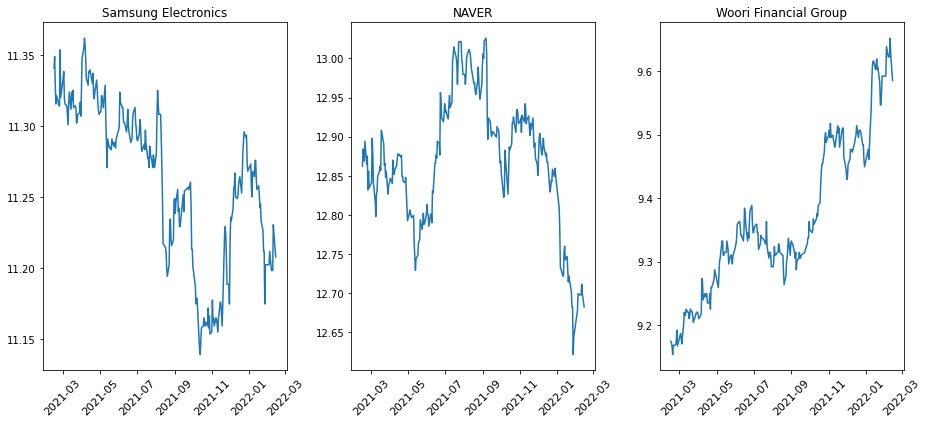

In [2]:
root_path = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
stock_list = {
    '005930': {
        'name': 'Samsung Electronics',
        'data': None,
        'file': '005930_2.KS.csv'
    },
    '035420': {
        'name': 'NAVER',
        'data': None
    },
    '316140': {
        'name': 'Woori Financial Group',
        'data': None
    },
}

for key, val in stock_list.items():
    if val.get('file'):
        dataset_filepath = os.path.join(root_path, val['file'])
    else:
        dataset_filepath = os.path.join(root_path, key + '.KS.csv')
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']

    # 결측치 처리
    ts = ts.interpolate(method='time')

    # 로그 변환 시도 
    val['data'] = np.log(ts)
    print(val['name'], '----------------')
    print(val['data'].head())
    print('')

i = 1
for val in stock_list.values():
    plt.subplot(130 + i)
    plt.title(val['name'])
    plt.plot(val['data'])
    plt.xticks(rotation=45, fontsize=11)
    i += 1
plt.tight_layout()

In [3]:
def plot_rolling_statistics(timeseries, window=12, name=''):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{name} - Rolling Mean & Standard Deviation')
    plt.show(block=False)

def augmented_dickey_fuller_test(timeseries, name=''):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print(f'{name} - Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

Samsung Electronics --------------------------------


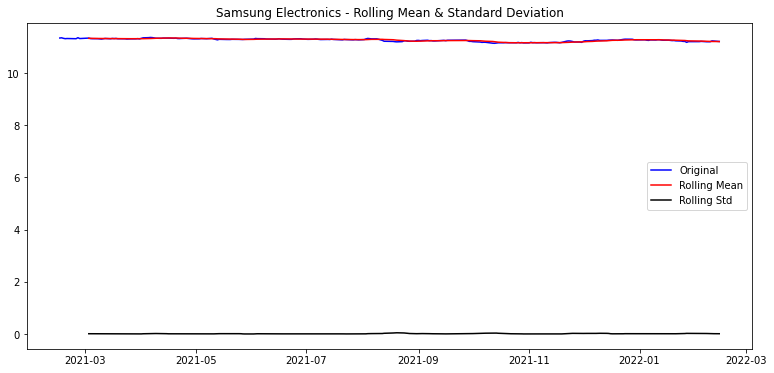

Samsung Electronics - Results of Dickey-Fuller Test:
Test Statistic                  -1.874104
p-value                          0.344340
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


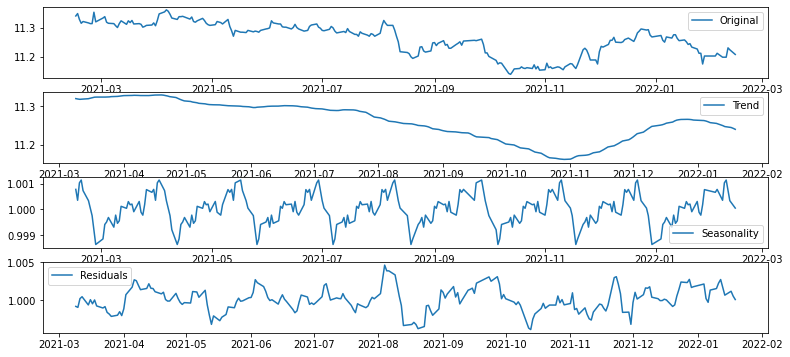



NAVER --------------------------------


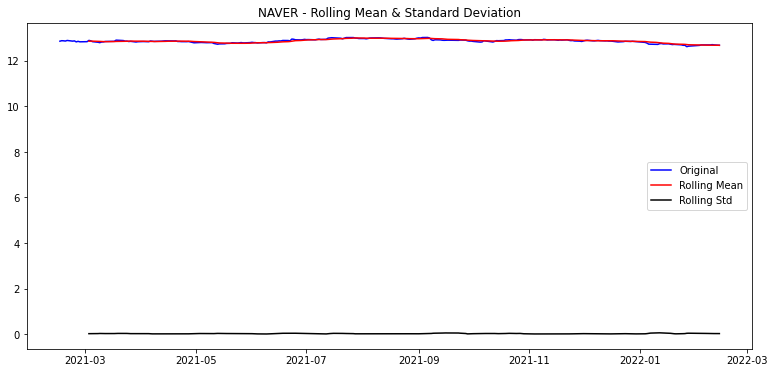

NAVER - Results of Dickey-Fuller Test:
Test Statistic                  -0.925708
p-value                          0.779389
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


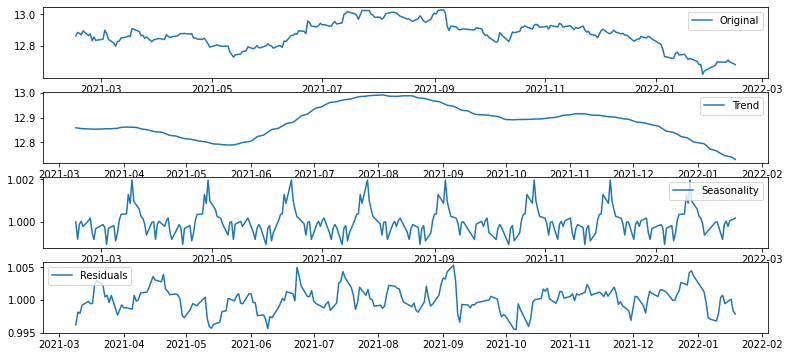



Woori Financial Group --------------------------------


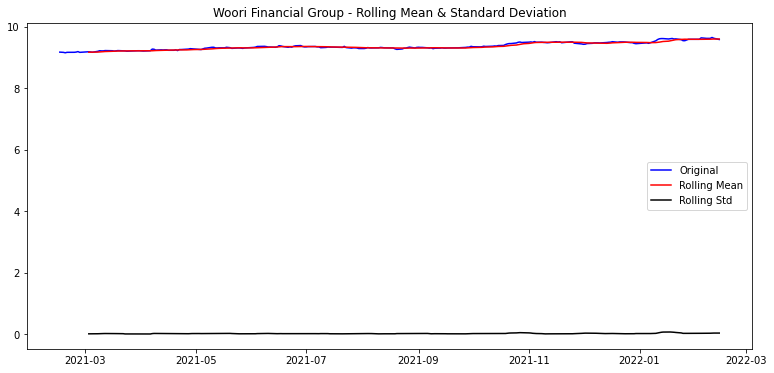

Woori Financial Group - Results of Dickey-Fuller Test:
Test Statistic                  -0.825276
p-value                          0.811584
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


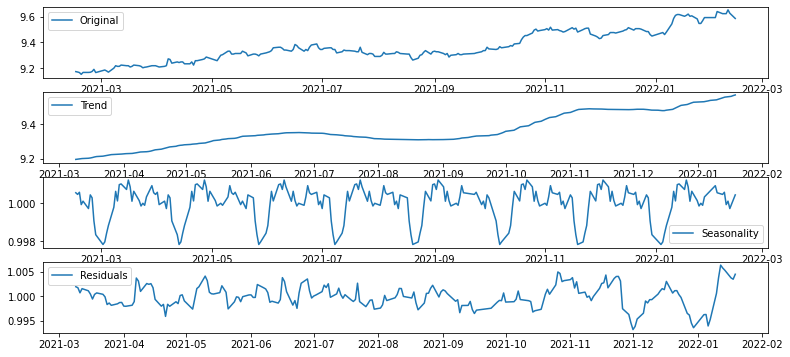

In [4]:
for val in stock_list.values():
    print(val['name'], '--------------------------------')
    # 정성적 그래프 분석
    plot_rolling_statistics(val['data'], window=12, name=val['name'])

    #정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(val['data'], name=val['name'])

    #시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(val['data'], model='multiplicative', period=30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    val['residual'] = decomposition.resid

    plt.subplot(411)
    plt.plot(val['data'], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(val['residual'], label='Residuals')
    plt.legend(loc='best')
    plt.show()
    print('\n')

In [5]:
for val in stock_list.values():
    val['residual'].dropna(inplace=True)
    augmented_dickey_fuller_test(val['residual'], name=val['name'])
    print('')

Samsung Electronics - Results of Dickey-Fuller Test:
Test Statistic                  -5.513497
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64

NAVER - Results of Dickey-Fuller Test:
Test Statistic                -6.096445e+00
p-value                        1.007402e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64

Woori Financial Group - Results of Dickey-Fuller Test:
Test Statistic                -6.310387e+00
p-value                        3.245471e-08
#Lags Used                     8.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00

## 학습, 테스트 데이터셋 생성

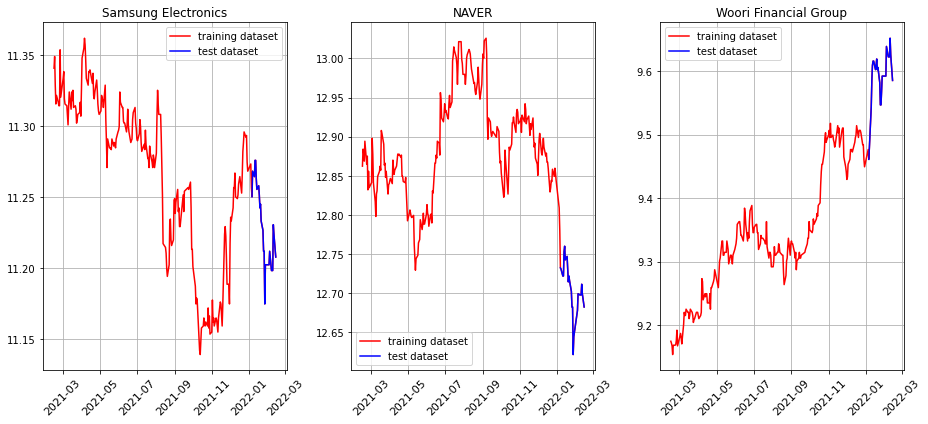

In [6]:
i = 1
for val in stock_list.values():
    val['train'], val['test'] = val['data'][:int(len(val['data'])*0.9)], val['data'][int(len(val['data'])*0.9):]
    plt.subplot(130 + i)
    plt.grid(True)
    plt.plot(val['data'], c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(val['test'], c='b', label='test dataset')
    plt.title(val['name'])
    plt.legend()
    plt.xticks(rotation=45, fontsize=11)
    i += 1
plt.tight_layout()

## 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

Samsung Electronics --------------


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


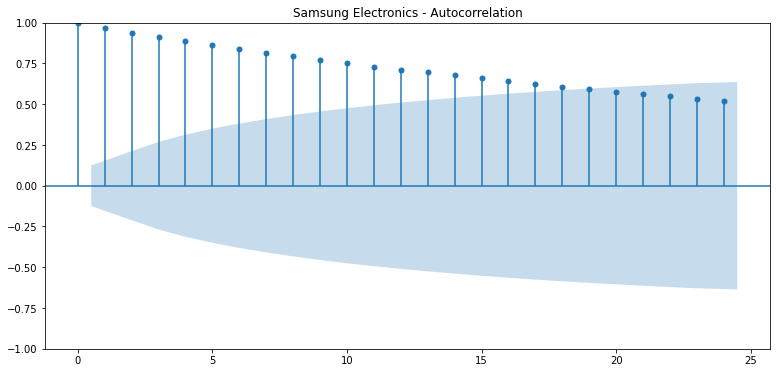

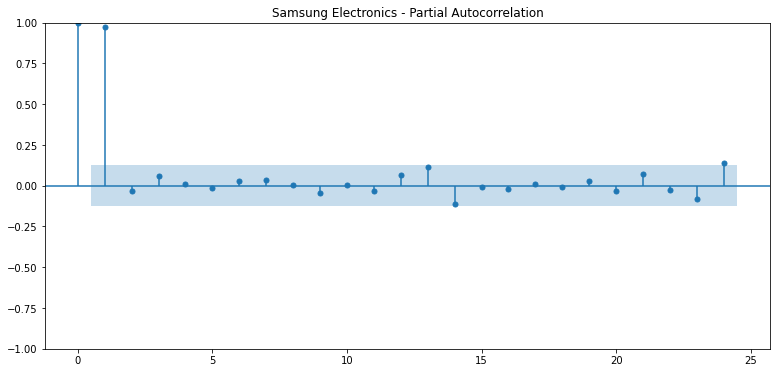


NAVER --------------


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


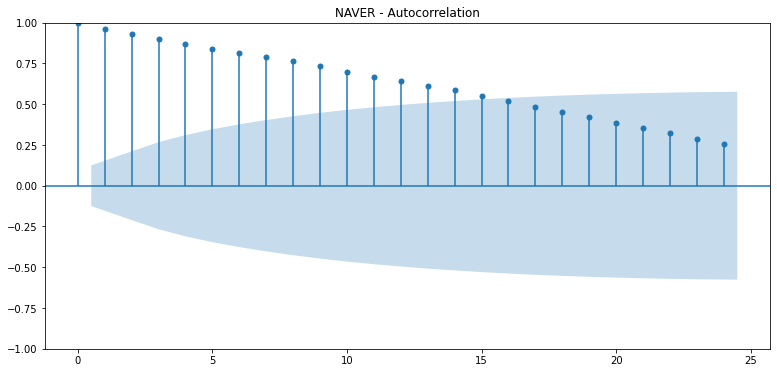

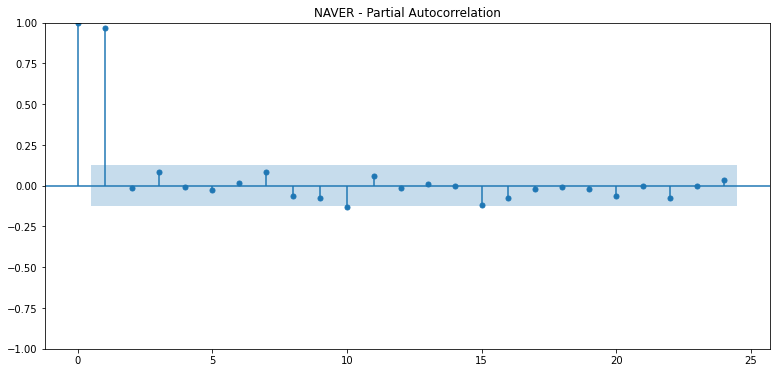


Woori Financial Group --------------


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


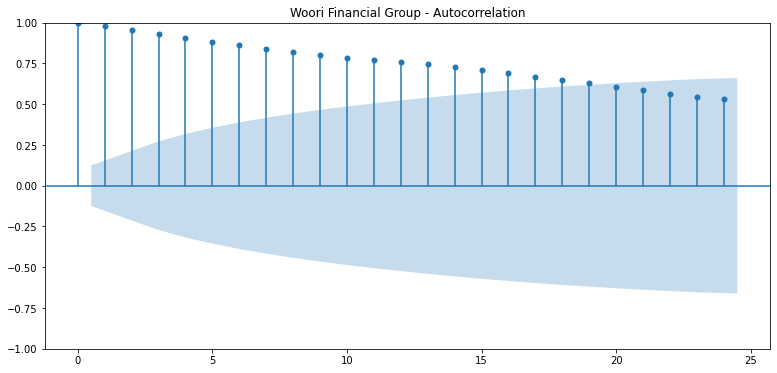

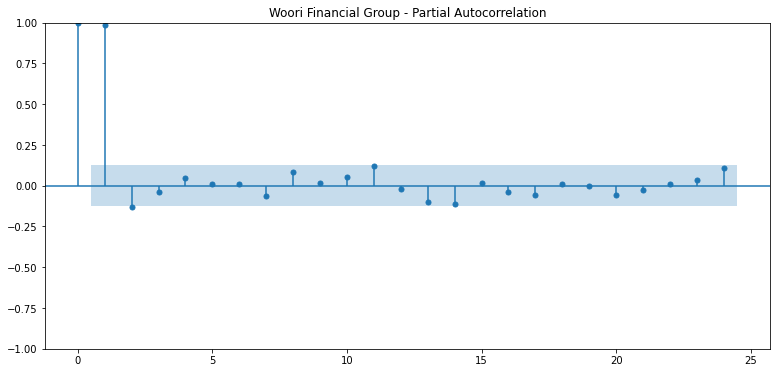

In [7]:
for val in stock_list.values():
    print(val['name'], '--------------')
    
    plot_acf(val['data'])   # ACF : Autocorrelation 그래프 그리기
    plt.title(f'{val["name"]} - Autocorrelation')
    plot_pacf(val['data'])  # PACF : Partial Autocorrelation 그래프 그리기
    plt.title(f'{val["name"]} - Partial Autocorrelation')
    plt.show()
    print('')

Samsung Electronics --------------
Samsung Electronics - Results of Dickey-Fuller Test:
Test Statistic                -1.524494e+01
p-value                        5.102003e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


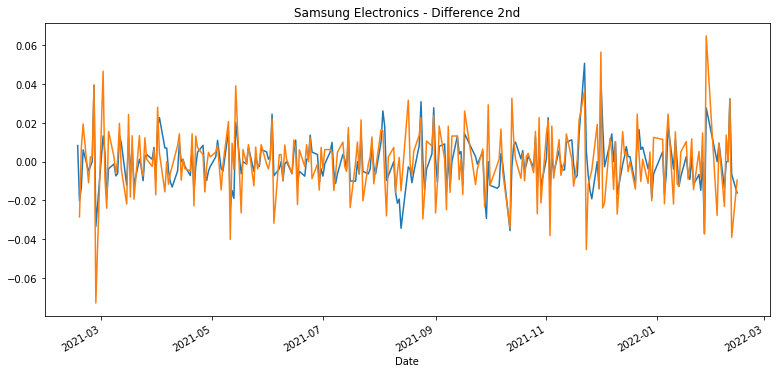

Samsung Electronics - Results of Dickey-Fuller Test:
Test Statistic                -7.933030e+00
p-value                        3.472041e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64



NAVER --------------
NAVER - Results of Dickey-Fuller Test:
Test Statistic                -1.198211e+01
p-value                        3.684168e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


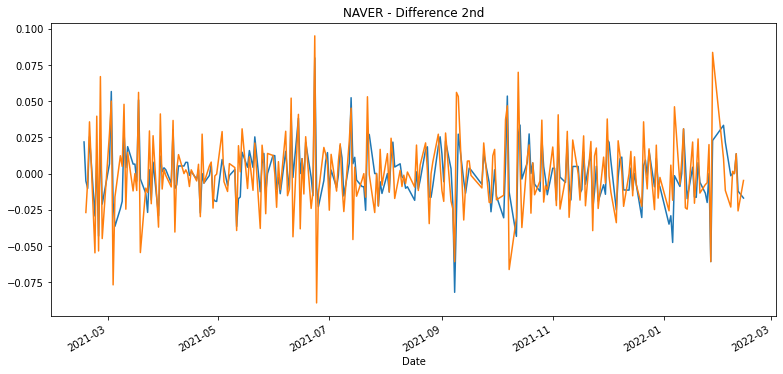

NAVER - Results of Dickey-Fuller Test:
Test Statistic                -7.769359e+00
p-value                        9.007306e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64



Woori Financial Group --------------
Woori Financial Group - Results of Dickey-Fuller Test:
Test Statistic                -1.451360e+01
p-value                        5.671985e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


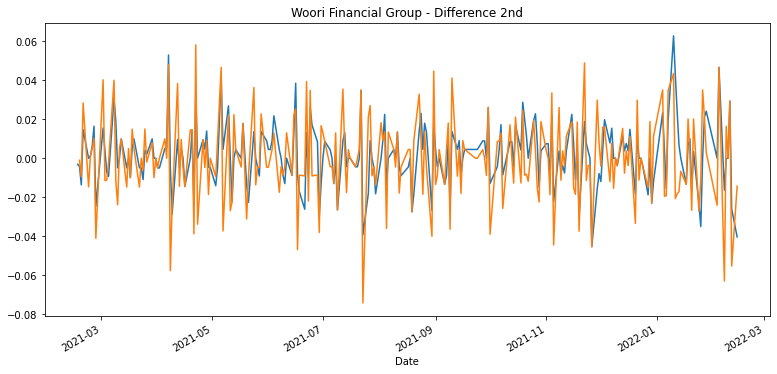

Woori Financial Group - Results of Dickey-Fuller Test:
Test Statistic                -8.474684e+00
p-value                        1.446082e-13
#Lags Used                     1.400000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64





In [8]:
for val in stock_list.values():
    print(val['name'], '--------------')

    # 1차 차분 구하기
    diff_1 = val['data'].diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1, val['name'])

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title=f'{val["name"]} - Difference 2nd')
    plt.show()

    augmented_dickey_fuller_test(diff_2, val['name'])
    print('\n\n')

* 위 그래프들을 토대로 ARIMA 파라미터를 조정

In [9]:
stock_list['005930']['param'] = (1, 2, 1)
stock_list['035420']['param'] = (1, 2, 3)
stock_list['316140']['param'] = (2, 2, 3)

## ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [10]:
for val in stock_list.values():
    # Build Model
    print(val['name'], '--------------')
    model = ARIMA(val['train'], order=val['param'])  
    val['fitted_m'] = model.fit() 

    print(val['fitted_m'].summary())
    print('\n')

Samsung Electronics --------------


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 657.227
Date:                Mon, 14 Feb 2022   AIC                          -1308.453
Time:                        14:12:43   BIC                          -1298.273
Sample:                             0   HQIC                         -1304.342
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0641      0.056      1.144      0.253      -0.046       0.174
ma.L1         -0.9997      0.873     -1.145      0.252      -2.711       0.712
sigma2         0.0001      0.000      1.155      0.2

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 2, 3)   Log Likelihood                 560.042
Date:                Mon, 14 Feb 2022   AIC                          -1110.085
Time:                        14:12:44   BIC                          -1093.117
Sample:                             0   HQIC                         -1103.232
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0514      0.696     -0.074      0.941      -1.416       1.313
ma.L1         -0.9332      0.704     -1.325      0.185      -2.313       0.447
ma.L2         -0.1339      0.689     -0.194      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


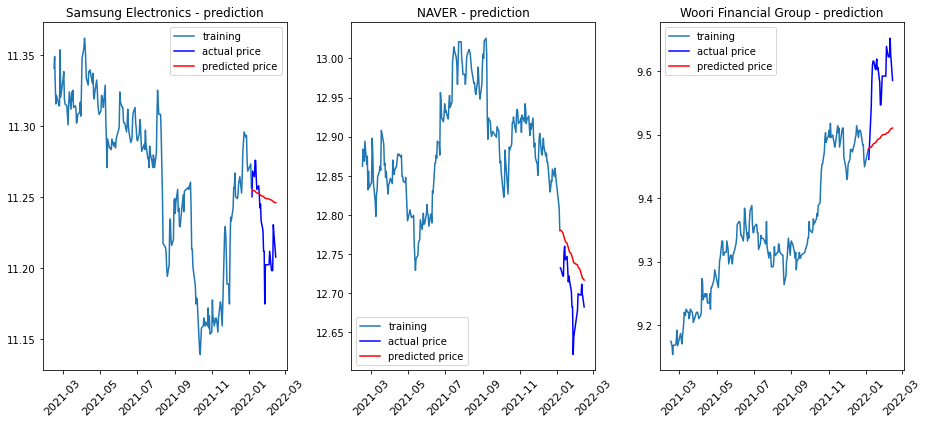

In [11]:
i = 1
for val in stock_list.values():
    # Forecast : 결과가 fc에 담깁니다. 
    fc = val['fitted_m'].forecast(len(val['test']), alpha=0.05)  # 95% conf
    val['fc'] = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(val['fc'], index=val['test'].index)   # 예측결과

    # Plot
    plt.subplot(130 + i)
    plt.plot(val['train'], label='training')
    plt.plot(val['test'], c='b', label='actual price')
    plt.plot(fc_series, c='r', label='predicted price')
    plt.legend()
    plt.xticks(rotation=45, fontsize=11)
    plt.title(f"{val['name']} - prediction")
    i += 1
plt.tight_layout()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

for val in stock_list.values():
    print(val['name'], '-------------------')
    mse = mean_squared_error(np.exp(val['test']), np.exp(val['fc']))
    print('MSE:', mse)

    mae = mean_absolute_error(np.exp(val['test']), np.exp(val['fc']))
    print('MAE:', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(val['test']), np.exp(val['fc'])))
    print('RMSE:', rmse)

    mape = np.mean(np.abs(np.exp(val['fc']) - np.exp(val['test'])) / np.abs(np.exp(val['test'])))
    print(f'MAPE: {mape * 100:.2f}%')
    print('\n')

Samsung Electronics -------------------
MSE: 5902600.630183544
MAE: 1977.303169656964
RMSE: 2429.52683257122
MAPE: 2.67%


NAVER -------------------
MSE: 263873541.35660577
MAE: 14138.021910616364
RMSE: 16244.184847403263
MAPE: 4.34%


Woori Financial Group -------------------
MSE: 2143721.3691541227
MAE: 1365.9947429959204
RMSE: 1464.1452691431007
MAPE: 9.20%




## 정리
* 파라미터 조정으로 3개종목 모두 10% 이하로 떨어트리는 데 성공
* 근 1년 장세가 안정적이지 않다보니 예측이 쉽지 않음
* 주가의 평이한 추이보다 외부변수가 크게 작용하는듯?